# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [419]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize_scalar
import pandas as pd

In [470]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        
        
    def fit(self, X, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        self.trees = []
        y_pred = np.zeros(len(y), dtype = float)
        for i in range(self.n_estimators):
            y_new = self._fit_predict_tree(X, y)
            y_pred -= y_new
        return self

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(criterion = 'mse', max_depth = self.max_depth)
        y_pred = np.zeros(len(y), dtype = float)
        grad = -2*(y - y_pred)
        tree.fit(x, grad)
        self.trees.append(tree)
        self.g = 1
        y_pred = self.g*self.learning_rate*tree.predict(x)
        return y_pred
        
    def predict(self, X):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred -= self.g*self.learning_rate*tree.predict(X)
        # your code here
        return y_pred
    
    
    
#https://habr.com/ru/company/mailru/blog/438562/
#https://notebook.community/ALEXKIRNAS/DataScience/Coursera/Machine-learning-data-analysis/Course%202/Week_04/grad_boosting

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [468]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [60]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [471]:
np.random.seed(19052019)

Grid = {
    'max_depth':range(1,20),
    'n_estimators':range(1,20)
}
min_mse = {
    'max_depth': 1,
    'n_estimators': 1,
    'mse': 10000
}
for i in Grid['max_depth']:
    for j in Grid['n_estimators']:
        gb = GradientBoosting(n_estimators = j, max_depth = i)
        gb.fit(X_train, y_train)
        y_pred = gb.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print('Est:', j, 'depth:', i, 'mse:', mse)
        if mse < min_mse['mse']:
            min_mse['max_depth'] = i
            min_mse['n_estimators'] = j
            min_mse['mse'] = mse

Est: 1 depth: 1 mse: 375.59197025947554
Est: 2 depth: 1 mse: 226.91452339197502
Est: 3 depth: 1 mse: 123.17403735025457
Est: 4 depth: 1 mse: 64.37051213431408
Est: 5 depth: 1 mse: 50.50394774415361
Est: 6 depth: 1 mse: 81.57434417977312
Est: 7 depth: 1 mse: 157.58170144117264
Est: 8 depth: 1 mse: 278.5260195283521
Est: 9 depth: 1 mse: 444.4072984413117
Est: 10 depth: 1 mse: 655.2255381800512
Est: 11 depth: 1 mse: 910.9807387445707
Est: 12 depth: 1 mse: 1211.6729001348697
Est: 13 depth: 1 mse: 1557.30202235095
Est: 14 depth: 1 mse: 1947.8681053928085
Est: 15 depth: 1 mse: 2383.371149260447
Est: 16 depth: 1 mse: 2863.8111539538686
Est: 17 depth: 1 mse: 3389.18811947307
Est: 18 depth: 1 mse: 3959.5020458180456
Est: 19 depth: 1 mse: 4574.752932988809
Est: 1 depth: 2 mse: 371.32963218336556
Est: 2 depth: 2 mse: 218.69182255487522
Est: 3 depth: 2 mse: 111.29294906728491
Est: 4 depth: 2 mse: 49.133011720594475
Est: 5 depth: 2 mse: 32.21201051480404
Est: 6 depth: 2 mse: 60.52994544991357
Est: 

Est: 17 depth: 11 mse: 3170.2497603079446
Est: 18 depth: 11 mse: 3716.7499535256725
Est: 19 depth: 11 mse: 4321.900080208815
Est: 1 depth: 12 mse: 370.3958714386512
Est: 2 depth: 12 mse: 221.06082678602135
Est: 3 depth: 12 mse: 104.30719316022066
Est: 4 depth: 12 mse: 41.64730753762711
Est: 5 depth: 12 mse: 19.36739835918559
Est: 6 depth: 12 mse: 41.49531119969922
Est: 7 depth: 12 mse: 99.96176583869561
Est: 8 depth: 12 mse: 212.5513796620014
Est: 9 depth: 12 mse: 363.45224230741206
Est: 10 depth: 12 mse: 554.1777836646914
Est: 11 depth: 12 mse: 805.0215136236029
Est: 12 depth: 12 mse: 1084.7855077432018
Est: 13 depth: 12 mse: 1421.4300429053783
Est: 14 depth: 12 mse: 1783.891661787297
Est: 15 depth: 12 mse: 2200.3046909716354
Est: 16 depth: 12 mse: 2645.0229525371337
Est: 17 depth: 12 mse: 3160.197512877493
Est: 18 depth: 12 mse: 3691.6176643706654
Est: 19 depth: 12 mse: 4298.819514512715
Est: 1 depth: 13 mse: 372.2143386190454
Est: 2 depth: 13 mse: 221.89938806405033
Est: 3 depth: 13

In [472]:
print(min_mse)

{'max_depth': 15, 'n_estimators': 5, 'mse': 14.750905249343829}


Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Нет

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [4]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [5]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [7]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb = XGBClassifier()
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

C:\Users\ilysh\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:23:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6992479535539458

In [19]:
train.dtypes

Month                object
DayofMonth           object
DayOfWeek            object
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_15min    object
dtype: object

In [37]:
X_train = train[['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)


In [43]:
from catboost import CatBoostClassifier
cat_features = [0, 1, 2, 3, 4, 5]

model = CatBoostClassifier()
model.fit(
    X_train_part, y_train_part,
    cat_features=cat_features,
    silent = True

)

roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7647352805174497

Даже базовый КатБуст выдает нужные результаты, что говорит о том, что именно его нужно использовать для конкретно этого датасета

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [378]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial.distance import euclidean

In [460]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here
        self.eps = eps
        self.min_samples = min_samples
        
    
    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here
        points = []
        for i in self.X:
            if dist(i, x) <= self.eps:
                points.append(i)
        return points
            
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        # your code here
        return euclidean(a, b)
    
    
    
    
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # your code here
        clusters = [0]*len(X)
        c = 0
        for i in range(len(X)):
            if clusters[i] != 0:
                continue
            Neighs = range_query(X[i])
            if len(Neighs) < self.min_samples:
                clusters[i] = -1
                continue
            c += 1
            clusters[i] = c
            SeedSet = Neighs
            for j in range(len(SeedSet)):
                if clusters[j] == -1:
                    clusters[j] = c
                if clusters[j] != 0:
                    continue
                clusters[j] = c
                Neighs = range_query(SeedSet[j])
                if len(Neighs) >= self.min_samples:
                    SeedSet.append(Neighs)
        return clusters
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here
        
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here

    

    
    
    
#https://towardsdatascience.com/understanding-dbscan-algorithm-and-implementation-from-scratch-c256289479c5

Проверим себя на простом примере:

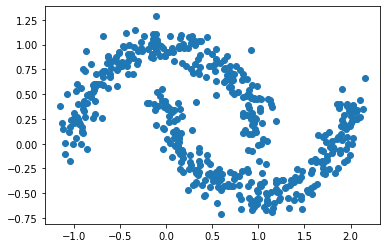

In [373]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

In [406]:
db = dbscan(eps = 0.05, min_samples = 5)
clusters = db.fit_predict(X)

NameError: name 'range_query' is not defined

Программа очень странно ругается на функцию range_query

Референс:

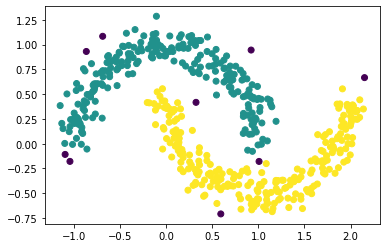

In [399]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=20).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

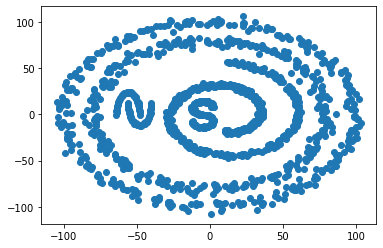

In [ ]:
# your code here

Или хотя бы что-нибудь такое: 

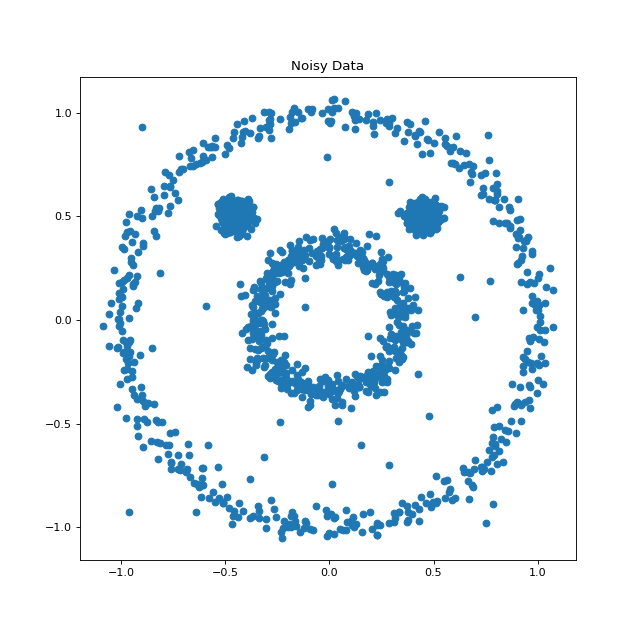

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [400]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=20).fit_predict(X)

Wall time: 17 ms


In [462]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

NameError: name 'range_query' is not defined

Wall time: 38 ms


Впринципе он работает не более чем в 100 раз медленнее)